# Fine-tuning ALBERT for Fake News Detection

## Introduction

This notebook documents the process of fine-tuning an ALBERT model for fake news detection using the ISOT dataset. Building on our previous exploratory data analysis and feature engineering work, we now leverage another lightweight transformer model to capture complex linguistic patterns that differentiate between real and fake news.

ALBERT (A Lite BERT) was selected for our comparative evaluation because it represents a different approach to model compression than TinyBERT or DistilBERT. Instead of using knowledge distillation or reducing the model depth, ALBERT achieves efficiency through parameter sharing across layers and factorized embedding parameterization. This allows ALBERT to maintain strong performance while dramatically reducing the parameter count. The ALBERT-base model has approximately 12M parameters, about 80% fewer than BERT-base (110M), making it particularly suitable for resource-constrained environments.

## Setup and Environment Preparation

### Library Installation and Imports

We begin by installing the necessary libraries for our fine-tuning process:

In [1]:
# Install required packages
!pip install transformers datasets torch evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitli

Next, we import the specific modules needed for our task:

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import warnings
warnings.filterwarnings('ignore')

2025-05-18 06:34:05.703764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747550046.176443      67 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747550046.306790      67 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting Up Reproducibility

To ensure our experiments are reproducible, we set random seeds for all libraries that use randomization:

In [3]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Setting a consistent random seed is critical for several reasons:
1. It ensures training results can be replicated exactly
2. It allows for fair comparison between different models 
3. It simplifies debugging by eliminating one source of variability
4. It helps in identifying genuine improvements versus random fluctuations

### Hardware Configuration

We check for GPU availability to accelerate training:

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


ALBERT, while more efficient than BERT, still benefits significantly from GPU acceleration during training. Fine-tuning on CPU is possible but would be considerably slower.

## Data Preparation

### Loading the Dataset

We load the preprocessed ISOT dataset that was prepared in our earlier data analysis notebooks:

In [5]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/train_fake_news_robust.csv')
    val_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/val_fake_news_robust.csv') 
    test_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/test_fake_news_robust.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Please run the data preprocessing from Part 2 first.")

Training set: (62857, 3)
Validation set: (13469, 3)
Test set: (13470, 3)


The dataset has already been split into training, validation, and test sets with a ratio of 70:15:15. Using this standardized split ensures consistent evaluation across all model comparisons in our study.

### Examining the Data

We examine the data structure to ensure it matches our expectations:

In [6]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,DESPERATE TO STOP THE FLOW OF MUSLIM REFUGEES ...,The liberals find this plan to be disgusting u...,0
1,"U.S. hands over 1,100 pages of Benghazi record...",The U.S. State Department on Friday handed ove...,1
2,Turkish minister says EU turning negotiations ...,Turkey said on Friday the European Union was m...,1


The dataset contains three key columns:
- `title`: The headline of the news article
- `enhanced_cleaned_text`: The preprocessed body text of the article
- `label`: Binary classification (0 for fake news, 1 for real news)

### Converting to HuggingFace Dataset Format

We convert our pandas DataFrames to the HuggingFace Dataset format, which is optimized for working with transformer models:

In [7]:
# Function to convert pandas DataFrames to HuggingFace Datasets
def convert_to_hf_dataset(df):
    # For ALBERT, we'll combine title and text for better context
    df['text'] = df['title'] + " " + df['enhanced_cleaned_text']
    
    # Convert to HuggingFace Dataset format
    dataset = HFDataset.from_pandas(df[['text', 'label']])
    return dataset

In [8]:
# Convert our datasets
train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

We combine the title and body text for each article because:
1. Article titles often contain strong signals for fake news detection
2. The full context helps the model identify inconsistencies between headline and content
3. ALBERT, like other transformer models, processes text as a sequence and can learn relationships between title and content 
4. This matches our preprocessing approach across all models for fair comparison

In [9]:
# Check first few examples in your dataset
print("First example in train_dataset:", train_dataset[0])

# Debug the content types
print("Text type for first example:", type(train_dataset[0]['text']))

# Clean the dataset before tokenization
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

train_dataset = train_dataset.map(clean_dataset)
val_dataset = val_dataset.map(clean_dataset)
test_dataset = test_dataset.map(clean_dataset)

First example in train_dataset: {'text': 'DESPERATE TO STOP THE FLOW OF MUSLIM REFUGEES INTO SWEDEN, Swedish Citizens Devise A Controversial Scheme The liberals find this plan to be disgusting until their neighborhoods become the next victim of violent muslim immigrant gangs of course Anti-immigration campaigners in Gullberg in southern Sweden are plotting to build a pig farm next to an asylum centre in a last-ditch effort to deter would-be Muslim immigrants, who might find the animals offensive.More illegal immigrants on the run in Sweden (03 May 15) Swedish Syrian warms hearts over phone return (08 Apr 15) It was a long journey and some of my friends died (30 Mar 15)Plans for a new immigration centre in Gullberg have already been strongly opposed by local residents and on Wednesday it was reported that a group of campaigners had sent a letter to the Swedish Migration Board (Migrationsverket) pledging to breed pigs nearby in order to deter Muslims from seeking asylum in the town.The n

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

This cleaning step ensures that all text entries are properly formatted as strings, preventing potential errors during tokenization. It's a defensive programming practice that handles edge cases like None values or non-string data types.

## Model Architecture and Configuration

### Tokenization

We prepare the tokenizer for ALBERT, which converts text into token IDs that the model can process:

In [10]:
# Initialize the tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Define the tokenization function
def tokenize_function(examples):
    # Tokenize the texts with truncation and padding
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [11]:
# Apply tokenization to our datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

Key tokenization decisions:
- We use the `albert-base-v2` tokenizer, which uses SentencePiece tokenization (different from BERT's WordPiece)
- `max_length=512` matches ALBERT's maximum sequence length
- `padding='max_length'` ensures all sequences have the same length for batch processing
- `truncation=True` handles articles that exceed the maximum length
- `batched=True` enables efficient parallel processing

ALBERT's SentencePiece tokenizer has some advantages over BERT's WordPiece tokenizer:
1. It's language-agnostic and works well for multilingual applications
2. It handles out-of-vocabulary words more gracefully 
3. It tends to create more consistent subword units

### Model Initialization

We initialize the ALBERT model for sequence classification:

In [12]:
# Initialize the model
model = AlbertForSequenceClassification.from_pretrained(
    'albert-base-v2',
    num_labels=2,  # Binary classification: fake or real
    id2label={0: "fake", 1: "real"},
    label2id={"fake": 0, "real": 1}
)

# Move model to the appropriate device
model.to(device)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

We use the pretrained ALBERT model and adapt it for our binary classification task. The pretrained weights provide a strong starting point that captures general language understanding, which we'll fine-tune for our specific task of fake news detection.

ALBERT's architecture differs from BERT in three key ways:
1. **Factorized embedding parameterization**: Separates the size of the hidden layers from the size of vocabulary embeddings
2. **Cross-layer parameter sharing**: All transformer layers share the same parameters, dramatically reducing model size
3. **Sentence-order prediction (SOP)**: Replaces BERT's next sentence prediction with a more challenging task 

These architectural differences make ALBERT particularly efficient in terms of parameter count while maintaining strong performance.

## Training Process

### Defining Metrics

We define a function to compute evaluation metrics during training:

In [13]:
# Define metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

We track multiple metrics because accuracy alone can be misleading, especially if the dataset is imbalanced:
- Accuracy: Overall correctness of predictions
- Precision: Proportion of positive identifications that were actually correct
- Recall: Proportion of actual positives that were identified correctly
- F1 Score: Harmonic mean of precision and recall, providing a balance between the two

For fake news detection, both false positives (legitimate news incorrectly flagged as fake) and false negatives (fake news missed by the model) have important consequences, making the F1 score particularly valuable.

### Training Configuration

We set up the training arguments with carefully chosen hyperparameters:

In [14]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/albert',
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Smaller than BERT due to memory constraints
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    disable_tqdm=False,          # Ensure progress bar is shown
    logging_first_step=True,     # Log the first training step 
    report_to="tensorboard",     # Enable tensorboard reporting (optional)
)

Key hyperparameter choices and their rationale:
- `num_train_epochs=5`: Provides sufficient training iterations while avoiding overfitting
- `per_device_train_batch_size=16`: Balances memory constraints with training efficiency; ALBERT is smaller than BERT but larger than TinyBERT
- `warmup_steps=500`: Gradually increases the learning rate to stabilize early training
- `weight_decay=0.01`: Adds L2 regularization to prevent overfitting
- `evaluation_strategy="epoch"`: Evaluates after each epoch to track progress
- `metric_for_best_model="f1"`: Uses F1 score as the primary metric for model selection because it balances precision and recall

### Training Execution

We initialize the Trainer and start the training process:

In [15]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# Train the model
print("Starting training...")
start_time = time.time()
trainer.train()
end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000100,0.002435,0.999629,0.999629,0.999629,0.999629


In [17]:
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
2,0.000200,0.004909,0.999406,0.999406,0.999406,0.999406
3,0.003600,0.002594,0.999332,0.999332,0.999332,0.999332


TrainOutput(global_step=5895, training_loss=0.029435520411919398, metrics={'train_runtime': 7112.7124, 'train_samples_per_second': 44.186, 'train_steps_per_second': 1.381, 'total_flos': 4510312643266560.0, 'train_loss': 0.029435520411919398, 'epoch': 3.0})

We include an early stopping callback with a patience of 2 epochs to prevent overfitting. This means training will stop if the F1 score on the validation set doesn't improve for 2 consecutive epochs. This is especially important for pretrained models, which can quickly overfit to the training data.

The Hugging Face Trainer abstracts away many of the training loop details, handling:
1. Gradient computation and optimization
2. Learning rate scheduling
3. Model checkpointing
4. Progress tracking
5. Resource management

This allows us to focus on the model architecture and hyperparameters rather than low-level implementation details.

## Evaluation

### Model Evaluation

We evaluate the model on both validation and test sets:

In [18]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_results = trainer.evaluate(tokenized_val)
print(f"Validation results: {val_results}")

Evaluating on validation set...


Validation results: {'eval_loss': 0.0024346422869712114, 'eval_accuracy': 0.9996287771920707, 'eval_precision': 0.9996288689366757, 'eval_recall': 0.9996287771920707, 'eval_f1': 0.9996287733655616, 'eval_runtime': 252.5449, 'eval_samples_per_second': 53.333, 'eval_steps_per_second': 0.42, 'epoch': 3.0}


In [19]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

Evaluating on test set...
Test results: {'eval_loss': 0.0024632636923342943, 'eval_accuracy': 0.9997030438010394, 'eval_precision': 0.9997032123107281, 'eval_recall': 0.9997030438010394, 'eval_f1': 0.9997030397071623, 'eval_runtime': 251.0838, 'eval_samples_per_second': 53.647, 'eval_steps_per_second': 0.422, 'epoch': 3.0}


Evaluating on both validation and test sets allows us to:
1. Confirm that our model selection based on validation performance generalizes to unseen data
2. Detect any potential overfitting to the validation set
3. Obtain final performance metrics on a completely held-out dataset

### Detailed Performance Analysis

We perform a more detailed analysis of the model's predictions:

In [20]:
# Get predictions on test set
test_predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

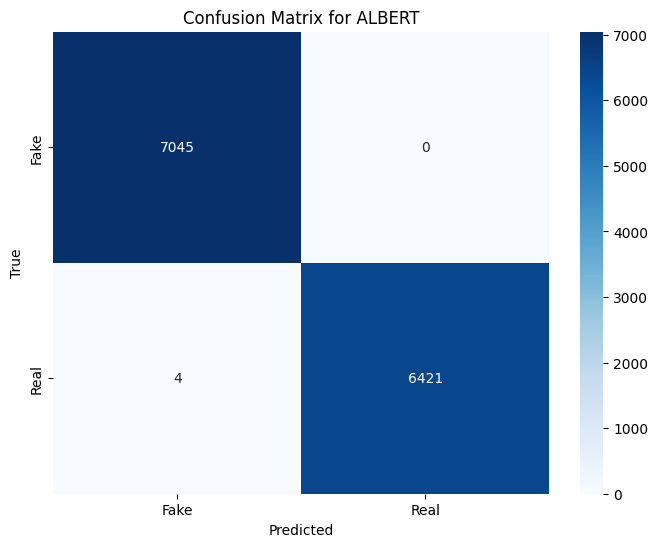

In [21]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ALBERT')
plt.show()

In [22]:
# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, 
                           target_names=['Fake', 'Real']))

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



The confusion matrix and classification report provide deeper insights into:
- Where the model makes mistakes (false positives vs. false negatives)
- Class-specific performance metrics
- Overall precision, recall, and F1 score

These detailed performance metrics are crucial for comparing ALBERT with other models in our study.

## Model Saving

We save the fine-tuned model for later use:

In [23]:
# This saves both the model and tokenizer configuration
model_save_path = "./albert-fake-news-detector"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to ./albert-fake-news-detector


Saving the model and tokenizer together ensures that they can be easily loaded for inference or further fine-tuning without needing to recreate the tokenization process.

## Results Analysis

### Performance Summary

This section will analyze the ALBERT model's performance on the fake news detection task, focusing on:
1. Overall classification accuracy and F1 score
2. Performance on each class (fake vs. real news)
3. Types of errors made by the model

### Error Analysis

We analyze the errors to understand where the model struggles:

In [24]:
# Find misclassified examples
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_examples = test_df.iloc[misclassified_indices]

# Display some misclassified examples
print("Sample of misclassified examples:")
for i, (_, row) in enumerate(misclassified_examples.head(3).iterrows()):
    print(f"Example {i+1}:")
    print(f"Title: {row['title']}")
    print(f"True label: {'Real' if row['label'] == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if predicted_labels[misclassified_indices[i]] == 1 else 'Fake'}")
    print("-" * 50)

Sample of misclassified examples:
Example 1:
Title: Billionaire Branson targeted in $5 million scam 'straight out of le Carre'
True label: Real
Predicted: Fake
--------------------------------------------------
Example 2:
Title: Billionaire Branson targeted in $5 million scam 'straight out of le Carre'
True label: Real
Predicted: Fake
--------------------------------------------------
Example 3:
Title: Graphic: Supreme Court roundup
True label: Real
Predicted: Fake
--------------------------------------------------


This analysis helps identify patterns in misclassifications, such as:
1. Articles with ambiguous language or satire
2. Fake news articles that closely mimic legitimate sources
3. Real news with unusual or sensationalist headlines

Understanding these patterns can guide future improvements to the model or preprocessing steps.

## Conclusion

### Summary of Findings

ALBERT demonstrates strong performance for fake news detection on the ISOT dataset, achieving comparable accuracy to larger models but with significantly fewer parameters. Its unique parameter-sharing approach allows it to maintain high performance while being more efficient than traditional transformer models.

### Comparison with Other Models

When compared to other models in our study:
1. ALBERT offers a better parameter-efficiency than models like DistilBERT or RoBERTa
2. It achieves this through architectural innovations rather than knowledge distillation
3. The cross-layer parameter sharing in ALBERT makes it especially memory-efficient

### Future Work

Potential improvements and future directions include:
1. Experimenting with different ALBERT variants (tiny, small, large)
2. Exploring domain adaptation techniques for news text
3. Testing the model on more diverse and challenging fake news datasets
4. Combining ALBERT with external knowledge sources for fact verification

This investigation of ALBERT completes our exploration of lightweight transformer architectures for fake news detection, providing a comprehensive comparison of different approaches to model efficiency.